In [1]:
# Load usual data libraries
import sys
print(sys.version)
import numpy as np
print 'numpy version:', np.__version__
import pandas as pd
print 'pandas version:', pd.__version__
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

2.7.11 |Anaconda 2.3.0 (x86_64)| (default, Dec  6 2015, 18:57:58) 
[GCC 4.2.1 (Apple Inc. build 5577)]
numpy version: 1.9.3
pandas version: 0.16.2


In [2]:
# Additional libraries
import re
import nltk
from nltk.collocations import *
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from collections import Counter
from wordcloud import WordCloud

In [3]:
# Set visualization parameters
print mpl.style.available
mpl.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 5) #make the plots bigger, adjust as needed.

[u'dark_background', u'bmh', u'grayscale', u'ggplot', u'fivethirtyeight']


In [4]:
# The data (in three csv files) cover all WhiteRights subreddit's comments from January 2015 to January 2016:
%ls wh*.csv

whiter_topwords_2015-05csv.csv  whiterights-Jan_15-16.csv
whiterights-FebJun_15.csv       whiterights-JulDec_15.csv


In [5]:
# Load each file as a pandas dataframe, use header from the first dataframe, set date fields to be transformed:
df1 = pd.read_csv('whiterights-Jan_15-16.csv', dtype = {'created_utc': np.float64, 'retrieved_on': np.float64})

In [6]:
df2 = pd.read_csv('whiterights-FebJun_15.csv', dtype = {'created_utc': np.float64, 'retrieved_on': np.float64}, 
                 usecols = df1.columns)

In [7]:
df3 = pd.read_csv('whiterights-JulDec_15.csv', dtype = {'created_utc': np.float64, 'retrieved_on': np.float64},
                 usecols = df1.columns)

In [8]:
df1.head()

,body,score_hidden,archived,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,parent_id,score,retrieved_on,controversiality,gilded,id,subreddit,ups,distinguished,author_flair_css_class
0,Just remind everyone that whites are a minorit...,NaN,NaN,NaN,HonorableJudgeHolden,Atheist Ethnonationalist,NaN,1453478587,t5_2rjto,t3_425yne,t3_425yne,4,1454659190,0,0,cz7uspp,WhiteRights,4,NaN,natsoc
1,"This is par for the course, as there has been ...",NaN,NaN,NaN,Exterminationist,Christian Identity,NaN,1452369392,t5_2rjto,t3_406o0v,t1_cys0ljz,2,1454385026,0,0,cys2kvv,WhiteRights,2,NaN,edl
2,[deleted],NaN,NaN,NaN,[deleted],NaN,NaN,1452043748,t5_2rjto,t3_3zgnar,t1_cynfs8c,2,1454306261,0,0,cynih7v,WhiteRights,2,NaN,NaN
3,Slavery my arse ..\n\n&gt;Witness the testimon...,NaN,NaN,NaN,TornadoMikeAlley,NaN,NaN,1453446048,t5_2rjto,t3_424fj3,t3_424fj3,1,1454653697,0,0,cz7j604,WhiteRights,1,NaN,NaN
4,"&gt; I may kill myself, but only after all the...",NaN,NaN,NaN,HonorableJudgeHolden,Atheist Ethnonationalist,NaN,1451667508,t5_2rjto,t3_3z0n3y,t1_cyidhph,-1,1454217420,0,0,cyidjkp,WhiteRights,-1,NaN,natsoc


In [9]:
# Check number of rows in each dataframe:
len(df1), len(df2), len(df3)

(3308, 8633, 10224)

In [10]:
# Concatenate dataframes into one with all comments from the subreddit WhiteRights from January 2015 to January 2016:
frames = [df1, df2, df3]
data = pd.concat(frames, ignore_index = True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22165 entries, 0 to 22164
Data columns (total 20 columns):
body                      22164 non-null object
score_hidden              14880 non-null object
archived                  14880 non-null object
name                      14880 non-null object
author                    22165 non-null object
author_flair_text         3087 non-null object
downs                     14880 non-null float64
created_utc               22165 non-null float64
subreddit_id              22165 non-null object
link_id                   22165 non-null object
parent_id                 22165 non-null object
score                     22165 non-null int64
retrieved_on              22024 non-null float64
controversiality          22165 non-null int64
gilded                    22165 non-null int64
id                        22165 non-null object
subreddit                 22165 non-null object
ups                       22165 non-null int64
distinguished             56 

In [12]:
# Convert unix time fields into datetime:
data['created_utc'] = pd.to_datetime(data['created_utc'], unit = 's')
data['retrieved_on'] = pd.to_datetime(data['retrieved_on'], unit = 's')

In [13]:
data.dtypes

body                              object
score_hidden                      object
archived                          object
name                              object
author                            object
author_flair_text                 object
downs                            float64
created_utc               datetime64[ns]
subreddit_id                      object
link_id                           object
parent_id                         object
score                              int64
retrieved_on              datetime64[ns]
controversiality                   int64
gilded                             int64
id                                object
subreddit                         object
ups                                int64
distinguished                     object
author_flair_css_class            object
dtype: object

In [14]:
# Visualize data with transformed datetime columns. 
# These columns won't be used in this analysis, but can be very useful later.
data.tail()

,body,score_hidden,archived,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,parent_id,score,retrieved_on,controversiality,gilded,id,subreddit,ups,distinguished,author_flair_css_class
22160,"this will not end well, for them not us. redpi...",False,False,t1_culccl5,grindmonkey,Clerical Fascist,0,2015-08-31 01:18:15,t5_2rjto,t3_3iz4qg,t3_3iz4qg,4,2015-09-07 03:44:15,0,0,culccl5,WhiteRights,4,NaN,edl
22161,Hell yes.,False,False,t1_cujl89o,bustedcougar,NaN,0,2015-08-29 09:25:10,t5_2rjto,t3_3ir62j,t1_cuj8dra,2,2015-09-06 18:48:21,0,0,cujl89o,WhiteRights,2,NaN,NaN
22162,Why can't we just accept that they're predispo...,False,False,t1_ctvay4j,la-raza-blanca,NaN,0,2015-08-07 22:03:53,t5_2rjto,t3_3g2fd2,t3_3g2fd2,1,2015-08-23 16:25:17,0,0,ctvay4j,WhiteRights,1,NaN,NaN
22163,[deleted],False,False,t1_cttzlmq,[deleted],NaN,0,2015-08-06 20:16:37,t5_2rjto,t3_3g1ouo,t3_3g1ouo,1,2015-08-23 10:03:10,0,0,cttzlmq,WhiteRights,1,NaN,NaN
22164,White guy went on websites like this shitty su...,False,False,t1_culzuh1,Pardonme23,NaN,0,2015-08-31 17:02:07,t5_2rjto,t3_3j0ku2,t1_culor02,0,2015-09-07 06:55:05,0,0,culzuh1,WhiteRights,0,NaN,NaN


In [15]:
# Enter list of stopwords retrieved from the internet to complement that of the NLPTK:
stopwords_list = ['a', 'about', 'above', 'across', 'after', 'afterwards']
stopwords_list += ['again', 'against', 'all', 'almost', 'alone', 'along']
stopwords_list += ['already', 'also', 'although', 'always', 'am', 'among']
stopwords_list += ['amongst', 'amoungst', 'amount', 'amp', 'an', 'and', 'another']
stopwords_list += ['any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere']
stopwords_list += ['are', 'around', 'as', 'at', 'back', 'be', 'became']
stopwords_list += ['because', 'become', 'becomes', 'becoming', 'been']
stopwords_list += ['before', 'beforehand', 'behind', 'being', 'below']
stopwords_list += ['beside', 'besides', 'between', 'beyond', 'bill', 'both']
stopwords_list += ['bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant']
stopwords_list += ['co', 'com', 'computer', 'con', 'could', 'couldnt', 'cry', 'de']
stopwords_list += ['describe', 'detail', 'did', 'do', 'done', 'down', 'due']
stopwords_list += ['during', 'each', 'eg', 'eight', 'either', 'eleven', 'else']
stopwords_list += ['elsewhere', 'empty', 'enough', 'etc', 'even', 'ever']
stopwords_list += ['every', 'everyone', 'everything', 'everywhere', 'except']
stopwords_list += ['few', 'fifteen', 'fifty', 'fill', 'find', 'fire', 'first']
stopwords_list += ['five', 'for', 'former', 'formerly', 'forty', 'found']
stopwords_list += ['four', 'from', 'front', 'full', 'further', 'get', 'give']
stopwords_list += ['go', 'gt', 'had', 'has', 'hasnt', 'have', 'he', 'hence', 'her']
stopwords_list += ['here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers']
stopwords_list += ['herself', 'him', 'himself', 'his', 'how', 'however', 'http', 'https']
stopwords_list += ['hundred', 'i', 'ie', 'if', 'in', 'inc', 'indeed']
stopwords_list += ['interest', 'into', 'is', 'it', 'its', 'itself', 'keep']
stopwords_list += ['last', 'latter', 'latterly', 'least', 'less', 'ltd', 'made']
stopwords_list += ['many', 'may', 'me', 'meanwhile', 'might', 'mill', 'mine']
stopwords_list += ['more', 'moreover', 'most', 'mostly', 'move', 'much']
stopwords_list += ['must', 'my', 'myself', 'name', 'namely', 'neither', 'never']
stopwords_list += ['nevertheless', 'next', 'nine', 'no', 'nobody', 'none']
stopwords_list += ['noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'of']
stopwords_list += ['off', 'often', 'on','once', 'one', 'only', 'onto', 'or']
stopwords_list += ['other', 'others', 'otherwise', 'our', 'ours', 'ourselves']
stopwords_list += ['out', 'over', 'own', 'part', 'per', 'perhaps', 'please']
stopwords_list += ['put', 'r', 'rather', 're', 's', 'same', 'see', 'seem', 'seemed']
stopwords_list += ['seeming', 'seems', 'serious', 'several', 'she', 'should']
stopwords_list += ['show', 'side', 'since', 'sincere', 'six', 'sixty', 'so']
stopwords_list += ['some', 'somehow', 'someone', 'something', 'sometime']
stopwords_list += ['sometimes', 'somewhere', 'still', 'such', 'system', 'take']
stopwords_list += ['ten', 'than', 'that', 'the', 'their', 'them', 'themselves']
stopwords_list += ['then', 'thence', 'there', 'thereafter', 'thereby']
stopwords_list += ['therefore', 'therein', 'thereupon', 'these', 'they']
stopwords_list += ['thick', 'thin', 'third', 'this', 'those', 'though', 'three']
stopwords_list += ['three', 'through', 'throughout', 'thru', 'thus', 'to']
stopwords_list += ['together', 'too', 'top', 'toward', 'towards', 'twelve']
stopwords_list += ['twenty', 'two', 'un', 'under', 'until', 'up', 'upon']
stopwords_list += ['us', 'very', 'via', 'was', 'we', 'well', 'were', 'what']
stopwords_list += ['whatever', 'when', 'whence', 'whenever', 'where']
stopwords_list += ['whereafter', 'whereas', 'whereby', 'wherein', 'whereupon']
stopwords_list += ['wherever', 'whether', 'which', 'while', 'whither', 'who']
stopwords_list += ['whoever', 'whole', 'whom', 'whose', 'why', 'will', 'with']
stopwords_list += ['within', 'without', 'would', 'www', 'yet', 'you', 'your']
stopwords_list += ['yours', 'yourself', 'yourselves']

In [16]:
# Combine lists of stopwords into a set:
nltk_list = stopwords.words('english') #153 items
stop_words = set(nltk_list + stopwords_list) #353 unique items combined

In [17]:
# Create function to clean text data (adapted from https://www.kaggle.com/c/word2vec-nlp-tutorial/):
def clean_content(raw_content):
    """Function to convert a raw content to a string of words
    The input is a single string (one reddit 'body'), and the
    output is a single string (a preprocessed reddit body)"""
    # 1. Remove non-letters (i.e. numbers, punctuation...)        
    letters_only = re.sub("[^a-zA-Z]", " ", raw_content) 
    #
    # 2. Remove HTML tags
    content_text = BeautifulSoup(letters_only).get_text() 
    #
    # 3. Convert to lower case, split into individual words
    words = content_text.lower().split()                             
    #
    # 4. Remove stop words
    meaningful_words = [w for w in words if not w in stop_words]   
    #
    # 5. Join all the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))

In [18]:
# Select column 'body' as the text data to work with, remove empty comments
raw_content = data['body'].dropna()
raw_content.head()

0    Just remind everyone that whites are a minorit...
1    This is par for the course, as there has been ...
2                                            [deleted]
3    Slavery my arse ..\n\n&gt;Witness the testimon...
4    &gt; I may kill myself, but only after all the...
Name: body, dtype: object

In [19]:
# Apply function to clean content
content = raw_content.apply(lambda x: clean_content(x))

In [20]:
print type(content)
content.head()

<class 'pandas.core.series.Series'>


0    remind whites minority california need stop ca...
1    par course influx limp wristed fag apologists ...
2                                              deleted
3    slavery arse witness testimony king dahomey bp...
4    kill nazis purged women poc lgbt people contro...
Name: body, dtype: object

In [21]:
# Create function to merge all rows of a series into one string (to be used to create a word cloud):
def create_string(series):
    """Function to create one string from the text content of a pandas series """
    wordstring = ''
    for row in series:
        wordstring += ' ' + row
    return wordstring

In [22]:
words = create_string(content) #merge each line (content) into one string

In [23]:
# Check result (last 200 characters)
words[-200:]

u'random people based race evidence gated black people prior crime black guy disgruntled employer killed people knew personal vendetta legally hate crime expect able tell difference echo chamber educate'

In [24]:
# Generate a word cloud by taking relative word frequencies into account, lower max_font_size:
wordcloud = WordCloud(max_font_size = 40, relative_scaling = 0.5).generate(words)

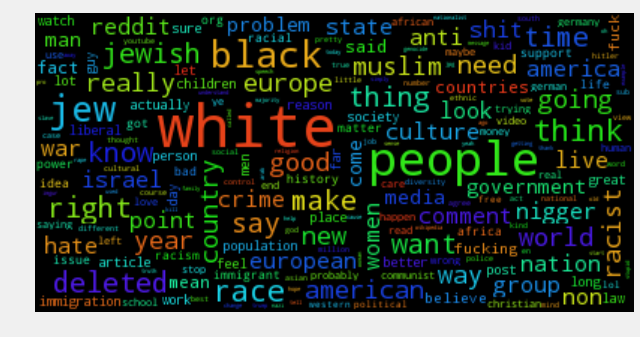

In [25]:
# Plot via matplotlib:
fig = plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [26]:
# Save word cloud image
#fig.savefig('wordcloud.pdf', bbox_inches='tight')

In [27]:
# Create a list of tokens (words)
word_list = words.split()

In [28]:
# Show number of tokens in the dataset as well as number of unique tokens:
len(word_list), len(set(word_list))

(419800, 32621)

In [29]:
# Count the frequency of each word using the collections library:
wordcount = Counter(word_list) #expects list of tokens, not one string

In [30]:
# Visualize the top 10 words with the highest counts in the corpus:
top10 =pd.Series(dict(wordcount)).order(ascending = False)[:10]
top10

white      6609
people     5276
like       3325
jews       2386
whites     2127
black      2042
think      1775
deleted    1579
race       1454
jewish     1312
dtype: int64

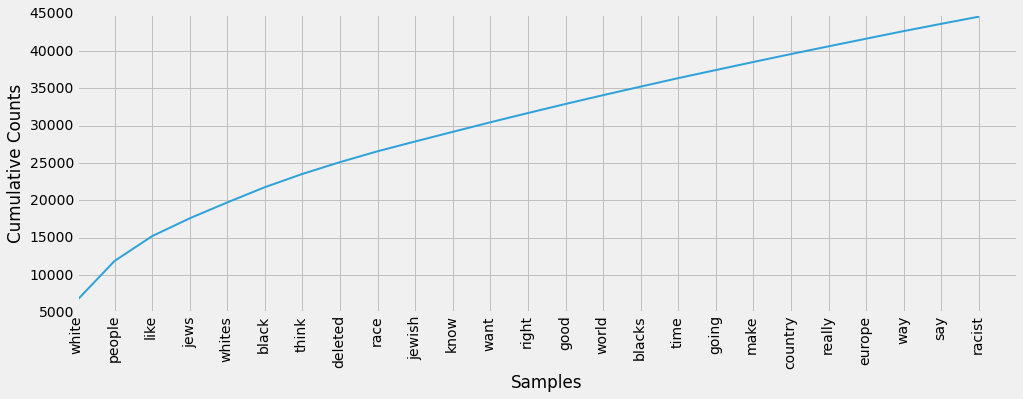

In [31]:
# Plot cumulative frequency distribution using the NLTK:
nltk.FreqDist(word_list).plot(25, cumulative=True)

In [32]:
# Analyzing bigrams: here are the first 10 bigrams in the text:
list(nltk.bigrams(word_list))[:10]

[(u'remind', u'whites'),
 (u'whites', u'minority'),
 (u'minority', u'california'),
 (u'california', u'need'),
 (u'need', u'stop'),
 (u'stop', u'calling'),
 (u'calling', u'non'),
 (u'non', u'minorities'),
 (u'minorities', u'minorities'),
 (u'minorities', u'par')]

In [33]:
# We want to find bigrams that occur more often than we would expect based on the frequency of the individual words. 
# The collocations function does this for us:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(word_list)
finder.apply_freq_filter(3) #ignores any bigram that occurs less than 3 times in the text
top50_bigrams = finder.nbest(bigram_measures.pmi, 50) #top 50 bigrams

In [34]:
# Visualize top 50 bigrams as a dataframe:
bigram_df = pd.DataFrame(top50_bigrams, columns = ['word_1', 'word_2']) 
bigram_df

,word_1,word_2
0,aboda,zara
1,agnes,selsing
2,banu,qurayza
3,benklassen,thewhiteman
4,bix,nood
5,caleb,shumaker
6,clint,eastwood
7,convertstometric,xhk
8,fiddle,jshell
9,golda,meir


In [35]:
# Save top 50 bigrams
#bigram_df.to_csv('Top50Bigrams.csv')

In [36]:
%ls off*.csv

offensive_words.csv      offensive_words_rev.csv


In [37]:
#Load list of offensive terms (collected and cleaned from four different internet sources):
offensive = pd.read_csv('offensive_words_rev.csv')
offensive.head()

,term
0,cunt
1,punt
2,abbo
3,abo
4,abortion


In [38]:
offensive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2311 entries, 0 to 2310
Data columns (total 1 columns):
term    2311 non-null object
dtypes: object(1)
memory usage: 36.1+ KB


In [39]:
#Remove duplicates and make all words lower case
offensive.term = offensive.term.apply(lambda x: x.lower()) #set all words to lower case
offensive.drop_duplicates(inplace = True)
len(offensive)

2067

In [40]:
#Reindex series
offensive.reset_index(level=0, inplace=True)
offensive = offensive['term']
type(offensive)

pandas.core.series.Series

In [41]:
pd.DataFrame(offensive).tail()

,term
2062,zigabo
2063,zipperhead
2064,zit
2065,face
2066,zubb


In [42]:
def offensive_count(token):
    """
    Function that takes a list of tokens and returns 
    a list of tuples counting membership (yes, no) in the
    list of offensive words (token, membership)
    """
    if token in offensive.tolist():
        result = (token, 1)
    else:
        result = (token, 0)
    return result

In [43]:
# Apply the offensive count function to the list of tokens, group results and visualize in a dataframe:
offensive_map = pd.DataFrame(map(offensive_count, word_list), columns = ['token', 'count']).groupby('token').sum()

In [44]:
# Reset the dataframe's index (always be sure whether you want to do this in place!)
offensive_map.reset_index(level = 0, inplace = True)
offensive_map.head()

,token,count
0,aa,0
1,aaa,0
2,aaaaaaaa,0
3,aaaaaaaaali,0
4,aaaaaaaaapy,0


In [45]:
# Show most frequent offensive words (count greater than 200):
offensive_map[offensive_map['count'] > 200] #40 tokens

,token,count
552,africa,465
554,african,266
965,american,659
1653,asian,206
2952,black,2042
2989,blacks,1142
3791,bullshit,219
5484,communist,287
6393,crime,587
6948,death,208


In [46]:
# Create a function to return a simple "offensiveness score (%)" from a reddit comment:
def offensive_score(comment):
    """
    Function that takes a comment (string of words), 
    counts membership of each word (yes or no) in the list 
    of offensive words (word, membership), and returns the
    sum of words in the offensive list divided by the total
    number of words in the comment.
    """
    results = []
    for token in comment.split():
        if token in offensive.tolist():
            results.append((token, 1))
        else:
            results.append((token, 0))
    
    return float(sum([item[1] for item in results])) / len(results)

In [47]:
#Example of comment made up entirely of words in the stopwords list:
print data.body[137]
content[137]

I did my part.  Did you?


''

In [48]:
#Some comments were processed so that they resulted in no content, thus causing division by zero
print clean_content(data.body[137])
print len(content)
len(content[content == '']) #109 empty comments after processing


22164


109

In [49]:
# Apply scoring function to text content
text_series = content[content != ''] #disregard empty values (no content after processing comment)
scored_content = text_series.apply(lambda x: offensive_score(x))
scored_content.head() #pandas series with scores

0    0.200000
1    0.066667
2    0.000000
3    0.039801
4    0.051724
Name: body, dtype: float64

In [50]:
# Create a dataframe  and add column to show the offensiveness score for each comment (row):
df_scored = pd.DataFrame(text_series)
df_scored['score'] = scored_content
df_scored.head()

,body,score
0,remind whites minority california need stop ca...,0.200000
1,par course influx limp wristed fag apologists ...,0.066667
2,deleted,0.000000
3,slavery arse witness testimony king dahomey bp...,0.039801
4,kill nazis purged women poc lgbt people contro...,0.051724


In [51]:
df_scored.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22055 entries, 0 to 22164
Data columns (total 2 columns):
body     22055 non-null object
score    22055 non-null float64
dtypes: float64(1), object(1)
memory usage: 516.9+ KB


In [52]:
# Show all commenst with score greater than 70% but below 100%:
df_scored[(df_scored['score'] > 0.7) & (df_scored['score'] < 1)]

,body,score
1758,slave god exist slave world shit fight,0.714286
3806,like israel fight fucking towelhead terrorists...,0.727273
9501,cracker mad cracker mad lol,0.800000
10409,blacks racist whites whites attention,0.800000
15408,whites racist soon shit,0.750000
15483,whites chanting blacks fucking sick,0.800000
17830,fuck niggers jew tells,0.750000
19235,dumb bitch probably deserved whites fucking suck,0.714286
20970,shoot niggers let rot,0.750000
21946,black dick sucking asshole,0.750000


In [53]:
# Read raw text content of some of the above comments:
data.body[19235] 

'That dumb bitch probably deserved it.\n\nWhites fucking suck.'

In [54]:
data.body[10409]

'Blacks are more racist than whites but whites get all the attention for it'

In [55]:
# Show the 20 most offensive scored comments (less than 100%):
df_scored[df_scored['score'] < 1].sort(columns='score', axis=0, ascending=False).head(20)

,body,score
9501,cracker mad cracker mad lol,0.800000
10409,blacks racist whites whites attention,0.800000
15483,whites chanting blacks fucking sick,0.800000
21946,black dick sucking asshole,0.750000
15408,whites racist soon shit,0.750000
20970,shoot niggers let rot,0.750000
17830,fuck niggers jew tells,0.750000
3806,like israel fight fucking towelhead terrorists...,0.727273
19235,dumb bitch probably deserved whites fucking suck,0.714286
1758,slave god exist slave world shit fight,0.714286


In [56]:
data.ix[15483]

body                      They're more whites chanting then blacks. Fuck...
score_hidden                                                            NaN
archived                                                                NaN
name                                                                    NaN
author                                                            PSYOP14EE
author_flair_text                                                       NaN
downs                                                                   NaN
created_utc                                             2015-11-16 15:46:33
subreddit_id                                                       t5_2rjto
link_id                                                           t3_3t00by
parent_id                                                         t3_3t00by
score                                                                     5
retrieved_on                                            2015-12-11 11:34:52
controversia

In [57]:
# A snapshot of the complete data of the worst (20 most offensive comments):
i = df_scored[(df_scored['score'] > 0.7) & (df_scored['score'] < 1)].index
data.ix[i]

,body,score_hidden,archived,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,parent_id,score,retrieved_on,controversiality,gilded,id,subreddit,ups,distinguished,author_flair_css_class
1758,I'm not a slave to a god that doesn't exist.\n...,False,False,t1_cnvnrha,SluttyGoyToy,NaN,0,2015-01-21 03:04:18,t5_2rjto,t3_2t4j7i,t3_2t4j7i,1,2015-02-21 04:30:30,0,0,cnvnrha,WhiteRights,1,NaN,NaN
3806,What if I like Israel because they fight the f...,False,False,t1_cp74bg6,Pardonme23,NaN,0,2015-03-07 08:27:09,t5_2rjto,t3_2y58h7,t1_cp6n3d5,-1,2015-03-29 10:52:18,0,0,cp74bg6,WhiteRights,-1,NaN,NaN
9501,cracker mad cracker mad lol,False,False,t1_cs07w99,jvvsh,NaN,0,2015-06-09 03:32:26,t5_2rjto,t3_3944k9,t1_cs07tfy,-1,2015-07-14 02:19:07,0,0,cs07w99,WhiteRights,-1,NaN,NaN
10409,Blacks are more racist than whites but whites ...,False,False,t1_cqpuxna,shamwoahh,NaN,0,2015-04-27 02:48:42,t5_2rjto,t3_33z4ml,t1_cqpur22,7,2015-05-26 07:06:23,0,0,cqpuxna,WhiteRights,7,NaN,NaN
15408,Whites who aren't racist yet soon will be if t...,NaN,NaN,NaN,CylonChick8,NaN,NaN,2015-11-29 16:57:37,t5_2rjto,t3_3ufras,t3_3ufras,1,2015-12-14 13:58:55,0,0,cxguzgt,WhiteRights,1,NaN,NaN
15483,They're more whites chanting then blacks. Fuck...,NaN,NaN,NaN,PSYOP14EE,NaN,NaN,2015-11-16 15:46:33,t5_2rjto,t3_3t00by,t3_3t00by,5,2015-12-11 11:34:52,0,0,cx24vjk,WhiteRights,5,NaN,NaN
17830,Fuck these niggers. They will do whatever the ...,NaN,NaN,NaN,no-na-ha,NaN,NaN,2015-12-27 19:26:27,t5_2rjto,t3_3yf9sm,t3_3yf9sm,3,2016-01-04 05:08:50,0,0,cycyw0z,WhiteRights,3,NaN,NaN
19235,That dumb bitch probably deserved it.\n\nWhite...,False,False,t1_ctp5smn,MilotisMelon,NaN,0,2015-08-02 20:08:12,t5_2rjto,t3_3fihcf,t3_3fihcf,-19,2015-08-22 10:54:07,0,0,ctp5smn,WhiteRights,-19,NaN,NaN
20970,just shoot the niggers and let them rot.\n,False,False,t1_cuauja6,Girlsbumsarefun,NaN,0,2015-08-21 17:04:15,t5_2rjto,t3_3hu9jl,t3_3hu9jl,7,2015-09-04 17:26:33,0,0,cuauja6,WhiteRights,7,NaN,NaN
21946,So just a black dick sucking asshole?,False,False,t1_ctszoux,Maximus_dinduicus,NaN,0,2015-08-06 00:09:15,t5_2rjto,t3_3fx2uk,t1_ctsyd3e,2,2015-08-23 05:15:42,0,0,ctszoux,WhiteRights,2,NaN,NaN
